코드 생성

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [94]:
OV = 10
ms = 100 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000



# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4.
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [95]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.000001

# 잡음의 크기 설정
num_samples = 1023 * ms * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))
imaginary_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [96]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)
        

cor_data = []
for value in data:
    cor_data.extend([value] * 20)


Signal 생성

In [97]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq, signal_length, OV = 1.023e6*OV):
    delayed_seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    signal = delayed_seq * oversampled_signal[:signal_length] + complex_noise
    return signal
    

Replica 신호 생성

In [98]:
def generate_replica_signal(code_delay, doppler_freq, code_freq, svNumber, signal_length = 1023*OV ,OV = 1.023e6*OV ):
    ca_code = np.array(codes[svNumber])
    ca_code = [chip for chip in ca_code for _ in range(int(OV//1.023e6))]
    delayed_code = np.roll(ca_code, code_delay)
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    replica =  delayed_code * oversampled_signal[:signal_length]
    return replica
    

Acquisition

In [99]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, signal_length, OV):
    
    # 신호 1ms씩 쪼개기
    signal_div = [signal[i:i+(1023*OV)] for i in range(0,len(signal), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber)
        
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica, mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
    # 20ms 안에서 bit boundary(B) 값 탐색
    True_replica = generate_replica_signal(max_code_delay, max_doppler_freq, code_freq, svNumber)
    cor_lst = []
    phase  = []
    for i in range(ms):
        cor = correlate(signal_div[i], True_replica, mode = 'valid')
        cor_lst.append(np.max(cor)) #cor_lst 얘로 phase 계산
        phase.append(np.arctan2(np.imag(cor), np.real(cor))) #왜 arctan2를 썼을까
    print(*phase)
    phase_diff = []
    for i in range(1, ms):
        phase_diff.append((phase[i]-phase[i-1]))
    print(*phase_diff)  
    mean_phasediff = sum(phase_diff)/ms
    
    
    return max_code_delay, max_doppler_freq, cor_lst, phase, phase_diff, corr_matrix
    
    
    
    
            

Acquisition 실행

In [100]:
#bit boundary 찾아야 한다
#노이즈 좀더 크게


# Parameters
B = rand.randint(0,20)  # Bit Boundary 무작위 설정 - bit boundary - 1ms안에서 맞추는거 (frame 동기화도 있음)
F = rand.randint(0,1023) # 1ms code 내 delay 설정



code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (B*1023+F)*OV) # Range of code delay in chips (0 ~ 1023*B + F)


true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
#true_doppler_freq = 10


received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, 1023*20*(ms//20)*OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, cor_lst, phase, phase_diff, corr_matrix = acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,1023*20*(ms//20)*OV,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40)




----------------------------------------
Frame Sync completed.
Frame delay : 645.0
Estimated_Frequency Offset : 1000.0
Max correlation : 548.7608679432067
----------------------------------------
[2.99605524] [2.71931569] [2.41970046] [2.08878173] [1.80479444] [1.58005947] [1.34009728] [0.98142172] [0.67331902] [0.42698061] [0.0956287] [-0.21073343] [-0.53840514] [-0.78553655] [-1.0347546] [-1.12851951] [1.5319439] [1.19472766] [0.99020329] [0.64102032] [0.39133237] [0.06576327] [-0.18872449] [-0.45926732] [-0.79659441] [-1.08572777] [-1.37168059] [-1.66558169] [-1.9419797] [-2.25551499] [-2.50245487] [-2.81604003] [-3.07906857] [2.83896966] [2.54505735] [2.28648752] [2.05236794] [1.71770323] [1.51829141] [1.17726271] [0.82851756] [0.51179997] [0.2793971] [0.00957802] [-0.27527605] [-0.63486206] [-0.9098466] [-1.13287896] [-1.41234769] [-1.72422702] [-2.0147491] [-2.32592082] [-2.64667498] [-2.86148429] [-3.10607655] [3.0651851] [-0.6383279] [-0.88808666] [-1.24056121] [-1.47839798] [-

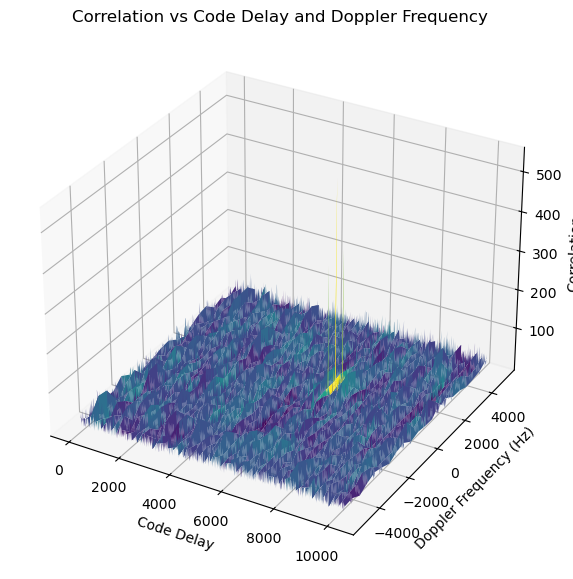

In [101]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



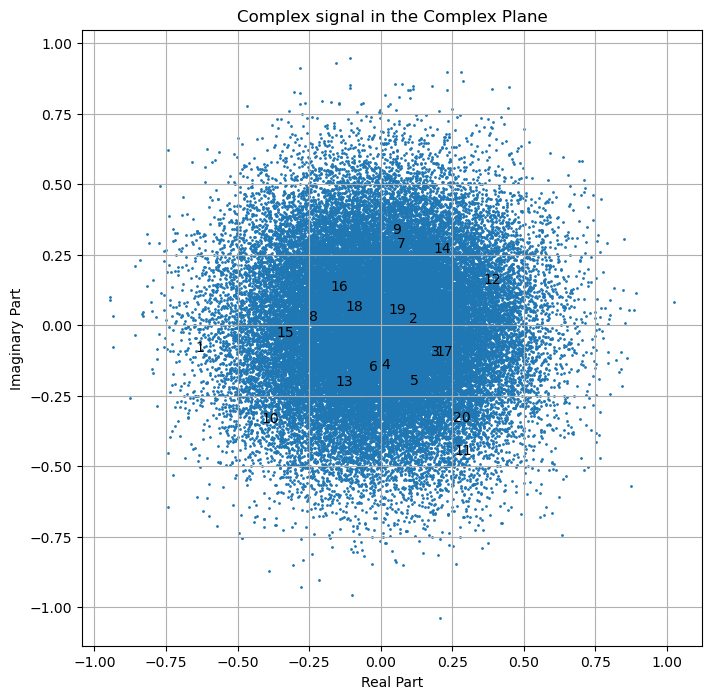

In [102]:
plt.figure(figsize=(8, 8))
#plt.scatter(np.real(received_signal[:1023*20]), np.imag(received_signal[:1023*20]), s=1)
plt.scatter(np.real(received_signal[::20]), np.imag(received_signal[::20]), s=1)

for i, txt in enumerate(range(1, 0 + 21)):
    plt.annotate(f'{txt}', (np.real(received_signal[i]), np.imag(received_signal[i])))
    
plt.title("Complex signal in the Complex Plane")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

In [103]:
cor_lst = [cor_lst[i] * cor_data[i] for i in range(100)]


16

Index 0: -15.85600828153056
Index 1: -17.166687862239066
Index 2: -18.960246845130982
Index 3: -16.271273142010152
Index 4: -12.876365049843889
Index 5: -13.748820515704145
Index 6: -20.550596121833095
Index 7: -17.652984412330767
Index 8: -14.114151324083553
Index 9: -18.985065798159148
Index 10: -17.553256717865786
Index 11: -18.7742063080045
Index 12: -14.1595867220911
Index 13: -14.279142784938568
Index 14: -5.372333486743855
Index 15: 152.43332502948948
Index 16: -19.321067103306312
Index 17: -11.718383106079674
Index 18: -20.006710810427382
Index 19: -14.306065422004131
Index 20: -18.65373573805299
Index 21: -14.581074543509796
Index 22: -15.500962263184885
Index 23: -19.327418712601155
Index 24: -16.566121011801837
Index 25: -16.383889883679405
Index 26: -16.83929233341388
Index 27: -15.836439812028559
Index 28: -17.964248632664493
Index 29: -14.148613168498125
Index 30: -17.96710578665738
Index 31: -15.070425660640957
Index 32: 339.07861392991026
Index 33: -16.8399351867752

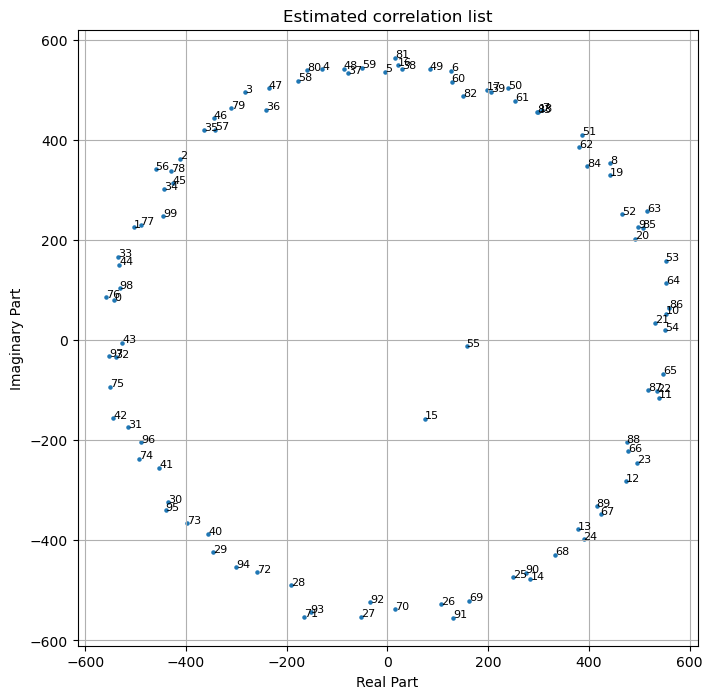

In [104]:
print(B)
print()
degree_list = [np.degrees(value) for sublist in phase_diff for value in sublist]
for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")

plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst), np.imag(cor_lst), s=5)

for i, txt in enumerate(range(0, 0 + 100)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

In [105]:

print(degree_list)
for i in range(len(degree_list)):
    if degree_list[i]<0:
        degree_list[i] = 360+degree_list[i]



#나중에 20개씩 슬라이딩하면서 튀는값을 찾아야함 - 찾으면 그거의 인덱스 반환

# 차이가 다른 값들과 많이 나는 값을 찾는 함수
def find_outlier(cor_lst):
    # 교차 상관 값들 사이의 차이를 저장할 변수 초기화
    max_difference = 0
    outlier_value = None
    outlier_index = None
    
    # 각 값들 사이의 차이를 계산하여 가장 큰 차이를 갖는 값을 찾음
    for i in range(len(cor_lst) - 1):
        difference = abs(cor_lst[i] - cor_lst[i + 1])
        if difference > max_difference:
            max_difference = difference
            outlier_value = cor_lst[i] if cor_lst[i] > cor_lst[i + 1] else cor_lst[i + 1]
            outlier_index = i if cor_lst[i] > cor_lst[i + 1] else i + 1
    
    return outlier_value, outlier_index

# 차이가 다른 값들과 많이 나는 값을 찾음
outlier_value, outlier_index = find_outlier(degree_list[:40])
print("Outlier Value:", outlier_value)
print("Outlier Index:", outlier_index)


print()
print(cor_lst)

[-15.85600828153056, -17.166687862239066, -18.960246845130982, -16.271273142010152, -12.876365049843889, -13.748820515704145, -20.550596121833095, -17.652984412330767, -14.114151324083553, -18.985065798159148, -17.553256717865786, -18.7742063080045, -14.1595867220911, -14.279142784938568, -5.372333486743855, 152.43332502948948, -19.321067103306312, -11.718383106079674, -20.006710810427382, -14.306065422004131, -18.65373573805299, -14.581074543509796, -15.500962263184885, -19.327418712601155, -16.566121011801837, -16.383889883679405, -16.83929233341388, -15.836439812028559, -17.964248632664493, -14.148613168498125, -17.96710578665738, -15.070425660640957, 339.07861392991026, -16.839935186775293, -14.814959735958583, -13.41406383138594, -19.17487524063417, -11.425455872392225, -19.53950547870808, -19.981624774073303, -18.146581279475704, -13.315704036402606, -15.459494392658513, -16.320936066393017, -20.60276032581914, -15.755453499304215, -12.778812997131606, -16.012379108849803, -17.86

In [106]:
import cmath


cor_lst_1 = cor_lst[:20]
cor_lst_2 = cor_lst[20:40] 
cor_lst_3 = cor_lst[40:60]
cor_lst_4 = cor_lst[60:80]
cor_lst_5 = cor_lst[80:100]




new_s_1 = [0] * (len(cor_lst_1) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

cumulative_phase = 0
for i in range(len(cor_lst_1)-1):
    cumulative_phase += phase_diff[i]
    new_s_1[i] = cor_lst_1[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_1)


new_s_2 = [0] * (len(cor_lst_2) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_2)-1):
    cumulative_phase += phase_diff[i+19]
    new_s_2[i] = cor_lst_2[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_2)


new_s_3 = [0] * (len(cor_lst_3) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_3)-1):
    cumulative_phase += phase_diff[i+39]
    new_s_3[i] = cor_lst_3[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_3)


new_s_4 = [0] * (len(cor_lst_4) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_4)-1):
    cumulative_phase += phase_diff[i+59]
    new_s_4[i] = cor_lst_4[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_4)



new_s_5 = [0] * (len(cor_lst_5) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_5)-1):
    cumulative_phase += phase_diff[i+79]
    new_s_5[i] = cor_lst_5[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_5)

[(-544.0444547467705-71.7922101976175j), (-545.186490616892-84.67224070376975j), (-538.9008418636065-101.06252153982186j), (-564.0945023833088-78.60167665978855j), (-555.125950279377-44.056764447999086j), (-533.464218348048-50.52247815823354j), (-540.5797567394237-116.99517067980855j), (-545.701446469864-89.50193942532434j), (-563.0789814175057-56.95194509442874j), (-536.6492092840857-100.8809193667606j), (-548.7486767318734-89.02117016195852j), (-542.5550190981774-99.92526529927571j), (-547.4491664421175-55.80968840443475j), (-531.9764079458453-55.35414219480549j), (-555.0345767621905+28.761234765323678j), (163.71129653186276+57.10001154561982j), (-539.1202177984211-104.62237793694482j), (-536.6047452005186-31.689440176633354j), (-534.7814797465428-110.43677074347832j)]
[(-525.9578720465676+77.09161671681889j), (-525.866577076533+77.07823527086654j), (-539.2538469236806+79.04045759092631j), (-546.9844956676734+80.1735677535811j), (-550.7094333534192+80.71954583210317j), (-529.35169644

C:\Users\siljn\AppData\Local\Temp\ipykernel_19476\250185475.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_s_1[i] = cor_lst_1[i] * cmath.exp(-1j * cumulative_phase)
C:\Users\siljn\AppData\Local\Temp\ipykernel_19476\250185475.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_s_2[i] = cor_lst_2[i] * cmath.exp(-1j * cumulative_phase)
C:\Users\siljn\AppData\Local\Temp\ipykernel_19476\250185475.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_s_

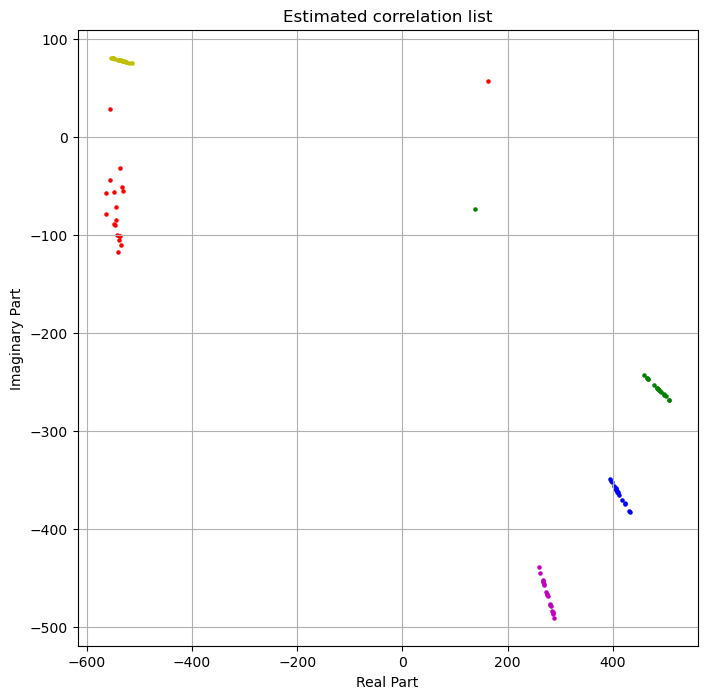

In [107]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_s_1), np.imag(new_s_1), s=5, label='New_s_1', c='r')
plt.scatter(np.real(new_s_2), np.imag(new_s_2), s=5, label='New_s_2', c='y')
plt.scatter(np.real(new_s_3), np.imag(new_s_3), s=5, label='New_s_3', c='g')
plt.scatter(np.real(new_s_4), np.imag(new_s_4), s=5, label='New_s_4', c='b')
plt.scatter(np.real(new_s_5), np.imag(new_s_5), s=5, label='New_s_5', c='m')
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()


## 밑에는

## 작업중

## 병렬구조 만들기 (Demod, DLL 하기 전)

신호를 I, Q로 쪼갠 뒤 각각을 계산해야함

In [108]:
# Extract real and imaginary parts separately
def spliter(signal):
    return np.real(signal), np.imag(signal)

real_part, imaginary_part = spliter(received_signal)

cur_code_delay = estimated_code_delay

E = generate_replica_signal(cur_code_delay - (OV // 2), estimated_doppler_freq, code_freq, svNumber)
P = generate_replica_signal(cur_code_delay, estimated_doppler_freq, code_freq, svNumber)
L = generate_replica_signal(cur_code_delay + (OV // 2), estimated_doppler_freq, code_freq, svNumber)

Real_E, Imag_E = spliter(E)
Real_P, Imag_P = spliter(P)
Real_L, Imag_L = spliter(L)

signal_div_Real = [real_part[i:i+(1023*OV)] for i in range(0,len(real_part), 1023*OV)]
signal_div_Imaginary = [imaginary_part[i:i+(1023*OV)] for i in range(0,len(imaginary_part), 1023*OV)]

def I_and_D(signal, replica):
    correlation = []
    for lst in signal:
        cor = correlate(lst, replica,mode='valid')
        correlation.append(np.max(cor))
    return list(correlation)

I_E = I_and_D(signal_div_Real, Real_E)
Q_E = I_and_D(signal_div_Imaginary, Imag_E)
I_P = I_and_D(signal_div_Real, Real_P)
Q_P = I_and_D(signal_div_Imaginary, Imag_P)
I_L = I_and_D(signal_div_Real, Real_L)
Q_L = I_and_D(signal_div_Imaginary, Imag_L)


print(I_E)
print(Q_E)
print(I_P)
print(Q_P)
print(I_L)
print(Q_L)

[-204.62623202496835, -187.16681305106454, -141.18795817996585, -99.35566722001067, -63.28863864932498, -3.8489189942875726, 41.85677336268972, 126.58110057466534, 161.7542965816748, 203.42533481769746, 192.54845982991844, 201.54726669638163, 196.29242792529692, 134.2923732109674, 112.28111430307229, 72.14737777644208, 4.060147071802099, 60.42544255630585, 124.26719078252846, 147.08770484688534, 190.17064069085154, 211.54927496009572, 202.73450066384336, 185.91009611044655, 151.19929358507446, 109.51388147934486, 22.603351840601732, -20.910296494770087, -60.641412136510496, -127.74779631726224, -161.46605822230447, -181.5859749863094, -200.018858852245, -184.73643116179937, -170.3016859894262, -132.5152001502795, -77.76588429327192, -36.42542450254504, 20.112932769069907, 75.49494396645767, 138.17563525500015, 183.98838072135862, 194.36525588019225, 196.20990613455305, 181.12983805466672, 159.64721018646114, 123.73516941736295, 71.67929344838751, 30.894577275111054, -29.184448865512685

In [109]:
#incoming signal 받고
#NCO carrier generator에서 받아와서 sin, cos 곱해
#여기까지  signal * sin, signal * cos


#그거랑 PRN이랑 곱해(E,P,L)
#여기까지 signal*sin*PRN...


# Residual code/carrier phase
remCodePhase = 0.0

# define residual carrier phase
remCarrPhase  = 0.0

# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco = 0.0
oldCarrError = 0.0

dataPosition = 0
blksize = 0


carrFreq = -3363.8
fs = 1023*OV*1000
codeLength = 1023
earlyLateSpacing = 0.5
chippingRate = 1023000
codeFreq = 1023000







In [110]:
# 91p
# Calculate filter coefficient values for code loop
def calculate_loop_coefficients(loop_noise_bandwidth, zeta, loop_gain, sum_int):
    """
    Calculates the loop coefficients tau1 and tau2.

    This process is discussed in sections 7.1-7.3 of Borre.

    Parameters:
    loop_noise_bandwidth (float): Loop noise bandwidth.
    zeta (float): Damping ratio.
    loop_gain (float): Loop gain.
    sum_int (float): Summation interval.

    Returns:
    tuple: Coefficient 1 (coeff1) and Coefficient 2 (coeff2).
    """
    # Solve for the natural frequency
    wn = loop_noise_bandwidth * 8 * zeta / (4 * zeta**2 + 1)

    # Solve for tau1 and tau2
    tau1 = loop_gain / (wn * wn)
    tau2 = (2.0 * zeta) / wn

    coeff1 = tau2 / tau1
    coeff2 = float(sum_int) / tau1

    return coeff1, coeff2


#91p참고 (loop_gain, sum_int는 모르겠다)
loop_noise_bandwidth = 20
zeta = 0.7
loop_gain = 1
sum_int = 1e-3
#coeffCode1, coeffCode2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
#coeffCar1, coeffCar2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
coeffCode1, coeffCode2 = 5.2972972972972965, 0.014317019722425127
coeffCar1, coeffCar2 = 264.86486486486484, 8.948137326515706

print(coeffCode1, coeffCode2)
print(coeffCar1, coeffCar2)

t_code = [item for item in t_code for _ in range(10)]

5.2972972972972965 0.014317019722425127
264.86486486486484 8.948137326515706


In [111]:

#Store the shift registers as a deque, so that deque.rotate() can be used.
from collections import deque  
import numpy as np

'''
GPS Gold Code generator. Initialized with the feedback taps for one satellite.
'''

#Feedback taps as defined in GPS spec
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]


def getCode(num, zero = False, samplesPerChip = 1, prn = 0):
    '''
    Returns a list of bits that form the Gold Code PRN of the designated satellite
    
    zero flag determines whether 0 or -1 is returned
    '''
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
        
    g = []

    for i in range(num):
        val = (g1[9] + g2[prn[0]] + g2[prn[1]]) % 2
        g.append(val)

        #Shift g1
        g1[9] = sum([g1[i] for i in g1tap]) % 2 
        g1.rotate()

        #Shift g2
        g2[9] = sum([g2[i] for i in g2tap]) % 2 
        g2.rotate()

    if(zero == False):
        #format GC to have -1 in place of 0
        for n,i in enumerate(g):
            if i==0:
                g[n]=-1
    
    if (samplesPerChip > 1 ):
        # Repeat each chip to match our ADC sample frequency
        gsamp = np.repeat(g, samplesPerChip)
        return gsamp
    return g

def getTrackingCode(sat):
    '''
    Returns a code ready to be used by Tracking.py
    '''
    code = np.array(getCode(1023, prn = sats[sat - 1]))

    # Need to add extra code chips to the ends so that it can 'slide'
    # back and forth during tracking.
    code = np.append(code,code[0])
    code = np.insert(code,0, code[len(code) - 2])
    return code


def getAcquisitionCode(sat, spc):
    '''
    Returns a code ready to be used by Acquisition.py
    '''
    return getCode(1023, samplesPerChip = spc, prn = sats[sat-1])



## Tracking loop test

In [112]:

import numpy as np
import matplotlib.pyplot as plt
import configparser



# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco   = 0.0
oldCarrError = 0.0

acquiredCarrFreq = estimated_doppler_freq
chippingRate = code_freq #codeFreqBasis

dataPosition = 0
CACode = getTrackingCode(RN)

I_P_list = []

# Process the requested number of code periods (num of ms to process)
for i in range(0, ms):
    print("\n------- %2.1f percent complete --------"%((i/ms)*100), end = '\r')
    # Find PLL error and update carrier NCO
    # Implement carrier loop discriminator (phase detector)

    # Update the phasestep based on code freq (variable) and
    # sampling frequency (fixed)
    codePhaseStep = np.real(codeFreq / fs) #맨아래에서 업데이트 시킨 codeFreq여기서 사용-LOOP
    
    
    #print("Old blksize: %d"%blksize)
    blksize = int(np.ceil((codeLength-remCodePhase) / codePhaseStep))
    #print("New blksize: %d"%blksize)
    #print("Old remCodePhase: %f" %remCodePhase)

    # Read in the appropriate number of samples to process this
    # iteration
    rawSignal = received_signal[dataPosition:dataPosition+blksize]
    dataPosition = dataPosition + blksize


    
    # Generate Early CA Code.
    tStart = remCodePhase - earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep - earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    earlyCode = CACode[tcode2]




    # Generate Late CA Code.
    tStart = remCodePhase + earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep + earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    lateCode = CACode[tcode2]


    # Generate Prompt CA Code.
    tStart = remCodePhase
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    promptCode = CACode[tcode2]

    
    
    # Figure out remaining code phase (uses tcode from Prompt CA Code generation):
    remCodePhase = (t_code[blksize-1]) - 1023.00   #t_code: 10230
    if abs(remCodePhase) > codePhaseStep:
        remCodePhase = np.sin(remCodePhase)*codePhaseStep
    else:
        remCodePhase = 0


    # Generate the carrier frequency to mix the signal to baseband
    time = np.array(range(0,blksize+1))/fs
    
    #print("Length of time array for cos and sin: %d" %len(time))
    # Get the argument to sin/cos functions
    trigarg = ((carrFreq * 2.0 * np.pi) * time) + remCarrPhase
    
    # Carry the leftover phase to the next argument by looking at the last element
    #remCarrPhase = trigarg[blksize] % (2 * np.pi)
    remCarrPhase_real = trigarg[blksize-1].real % (2 * np.pi)
    remCarrPhase_imag = trigarg[blksize-1].imag % (2 * np.pi)
    remCarrPhase = remCarrPhase_real + 1j * remCarrPhase_imag


    # Finally compute the signal to mix the collected data to baseband
    carrCos = np.cos(trigarg[0:blksize])
    carrSin = np.sin(trigarg[0:blksize])
    
    # First mix to baseband
    #print(len(carrCos), len(rawSignal))
    qBasebandSignal = carrCos * rawSignal #38192, 30026
    iBasebandSignal = carrSin * rawSignal
    
    # Now get early, late, and prompt values for each
    I_E = np.sum(earlyCode  * iBasebandSignal) #1023, 38192
    Q_E = np.sum(earlyCode  * qBasebandSignal)
    I_P = np.sum(promptCode * iBasebandSignal)
    Q_P = np.sum(promptCode * qBasebandSignal)
    I_L = np.sum(lateCode   * iBasebandSignal)
    Q_L = np.sum(lateCode   * qBasebandSignal)
    
    I_P_list.append(I_P + Q_P)


    carrError = np.arctan(Q_P / I_P) / (2.0 * np.pi)
    #print(Q_P[i])
    
    # Implement carrier loop filter and generate NCO command
    carrNco = oldCarrNco + coeffCar1 * (carrError - oldCarrError) + carrError * coeffCar2
    oldCarrNco   = carrNco
    oldCarrError = carrError

    # Modify carrier freq based on NCO command
    carrFreq = acquiredCarrFreq + carrNco





    # Find DLL error and update code NCO -------------------------------------
    codeError = (np.sqrt(I_E * I_E + Q_E * Q_E) - np.sqrt(I_L * I_L + Q_L * Q_L)) /\
                            (np.sqrt(I_E * I_E + Q_E * Q_E) + np.sqrt(I_L * I_L + Q_L * Q_L))
    
    # Implement code loop filter and generate NCO command
    codeNco = oldCodeNco + coeffCode1 * (codeError - oldCodeError) + codeError * coeffCode2
    oldCodeNco   = codeNco
    oldCodeError = codeError
    
    # Modify code freq based on NCO command
    codeFreq = chippingRate - codeNco





#print(codeNco)
#print(codeFreq)
#print(codeError)
#print(carrError)


------- 0.0 percent complete --------
------- 1.0 percent complete --------
------- 2.0 percent complete --------
------- 3.0 percent complete --------
------- 4.0 percent complete --------
------- 5.0 percent complete --------
------- 6.0 percent complete --------
------- 7.0 percent complete --------
------- 8.0 percent complete --------
------- 9.0 percent complete --------
------- 10.0 percent complete --------
------- 11.0 percent complete --------
------- 12.0 percent complete --------
------- 13.0 percent complete --------
------- 14.0 percent complete --------
------- 15.0 percent complete --------
------- 16.0 percent complete --------
------- 17.0 percent complete --------
------- 18.0 percent complete --------
------- 19.0 percent complete --------
------- 20.0 percent complete --------
------- 21.0 percent complete --------
------- 22.0 percent complete --------
------- 23.0 percent complete --------
------- 24.0 percent complete --------
------- 25.0 percent complete ----

Demodulation

In [113]:
Prompt = []
for i in range(len(I_P_list)):
    if I_P_list[i] > 0:
        Prompt.append(1)
    else:
        Prompt.append(-1)

print(len(data))
print('data :', *data, sep = " ",)

print(len(Prompt))
print('est :', *Prompt, sep = " ")
# 리스트를 20개씩 묶기
grouped_lists = [Prompt[i:i+20] for i in range(0, len(Prompt), 20)]

# 각 그룹의 평균을 계산하고, 1 또는 -1로 변환하여 새로운 리스트 생성
result_lists = []
for group in grouped_lists:
    avg = sum(group) / len(group)
    result_lists.append(1 if avg > 0 else -1) 

# 결과 출력
print("\n\nresult", result_lists)



5
data : 1 1 -1 -1 -1
100
est : 1 -1 -1 -1 1 -1 1 1 1 -1 1 1 -1 1 1 1 -1 1 -1 1 -1 1 -1 -1 1 -1 1 1 -1 -1 -1 1 1 -1 1 -1 1 1 1 -1 -1 -1 -1 -1 1 -1 -1 1 -1 1 -1 1 1 1 1 -1 1 -1 -1 -1 1 -1 -1 -1 1 1 1 -1 -1 1 1 -1 1 1 -1 -1 1 -1 1 1 -1 1 1 1 -1 -1 1 1 -1 1 -1 -1 -1 1 1 1 -1 -1 -1 -1


result [1, -1, -1, 1, -1]


결과 Plot